In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import os
import PIL
import pathlib

#1. Data

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 11s 0us/step


In [3]:
data_dir = pathlib.Path(data_dir)

for file in data_dir.iterdir():
    print(file.name)

LICENSE.txt
roses
sunflowers
tulips
dandelion
daisy


In [4]:
# 이미지 파일 갯수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


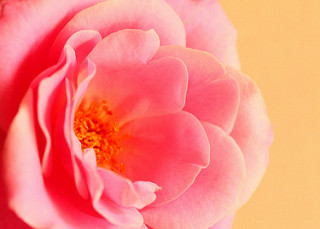

In [33]:
# Roses
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[6]))

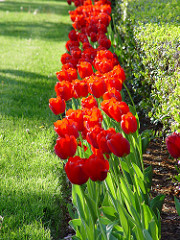

In [6]:
# Tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[47]))

# 2. Data Set

In [7]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 5
epochs = 15

In [8]:
# train_data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'training',
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
# validation_data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'validation',
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
print(train_ds.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [11]:
class_names = train_ds.class_names

In [12]:
for images, labels in train_ds.take(1):
    # images는 첫 번째 배치의 이미지, labels는 첫 번째 배치의 레이블
    print("Batch shape:", images.shape)
    print("Label batch:", labels)


Batch shape: (32, 180, 180, 3)
Label batch: tf.Tensor([2 1 4 3 1 2 1 2 4 1 4 4 3 4 1 2 0 4 1 1 1 4 3 2 3 1 4 2 2 3 4 3], shape=(32,), dtype=int32)


# 3. Visaulization

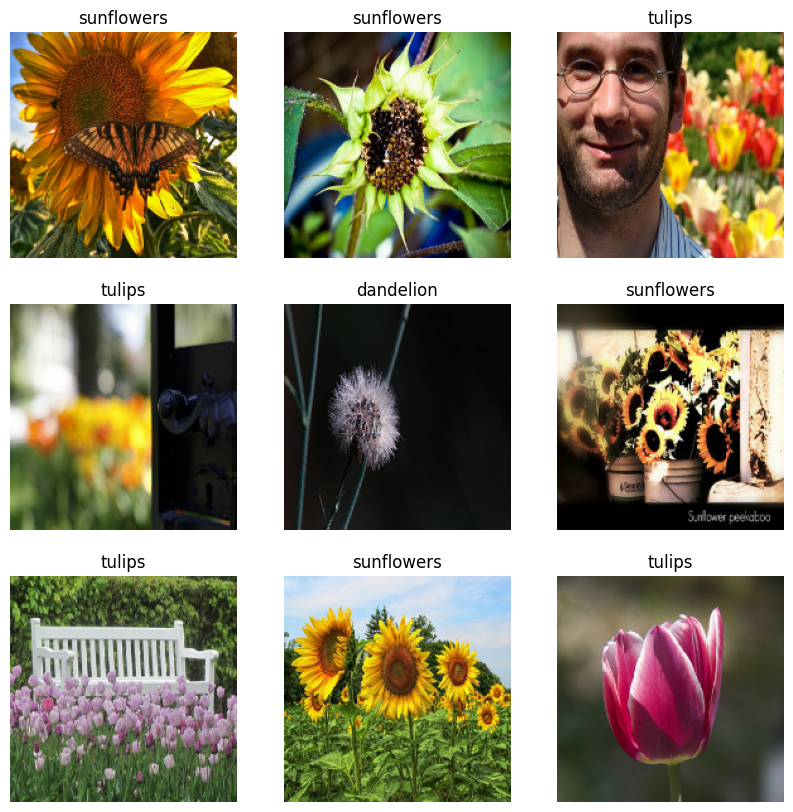

In [13]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [14]:
# batch.shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
# 데이터 입력 파이프라인 최적화
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# 데이터 정규화
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
import numpy as np
normalizerd_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # 정규화 레이어
image_batch, labels_batch = next(iter(normalizerd_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.98584765


# 4. Model

In [18]:
model = keras.Sequential([
  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [21]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs)

Epoch 1/15
92/92 [==============================] - 9s 41ms/step - loss: 1.2029 - accuracy: 0.5089 - val_loss: 1.0609 - val_accuracy: 0.5627
Epoch 2/15
92/92 [==============================] - 2s 21ms/step - loss: 0.9157 - accuracy: 0.6417 - val_loss: 0.8948 - val_accuracy: 0.6580
Epoch 3/15
92/92 [==============================] - 2s 20ms/step - loss: 0.7358 - accuracy: 0.7187 - val_loss: 0.8867 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 2s 20ms/step - loss: 0.5363 - accuracy: 0.8048 - val_loss: 0.9767 - val_accuracy: 0.6471
Epoch 5/15
92/92 [==============================] - 2s 22ms/step - loss: 0.3347 - accuracy: 0.8842 - val_loss: 1.0754 - val_accuracy: 0.6730
Epoch 6/15
92/92 [==============================] - 2s 20ms/step - loss: 0.1846 - accuracy: 0.9455 - val_loss: 1.1584 - val_accuracy: 0.6540
Epoch 7/15
92/92 [==============================] - 2s 20ms/step - loss: 0.1241 - accuracy: 0.9608 - val_loss: 1.4828 - val_accuracy: 0.6567
Epoch 8/15
92

In [22]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

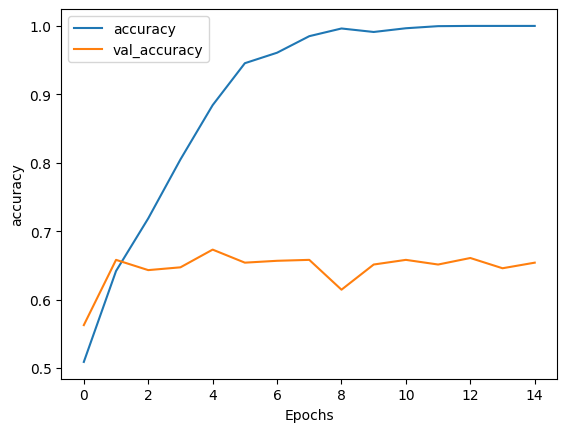

In [23]:
plot_graphs(history, 'accuracy')

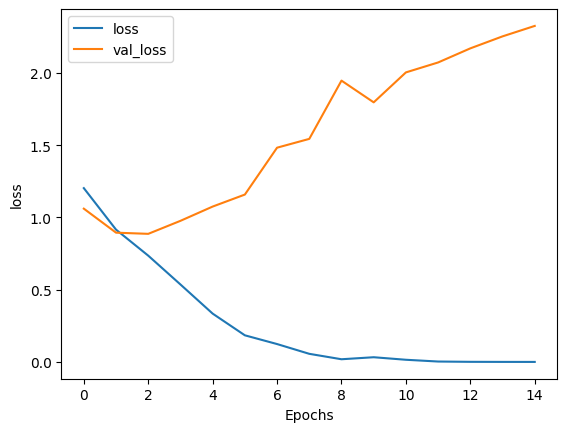

In [24]:
plot_graphs(history, 'loss')

# 5. Data Augmentation

In [25]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

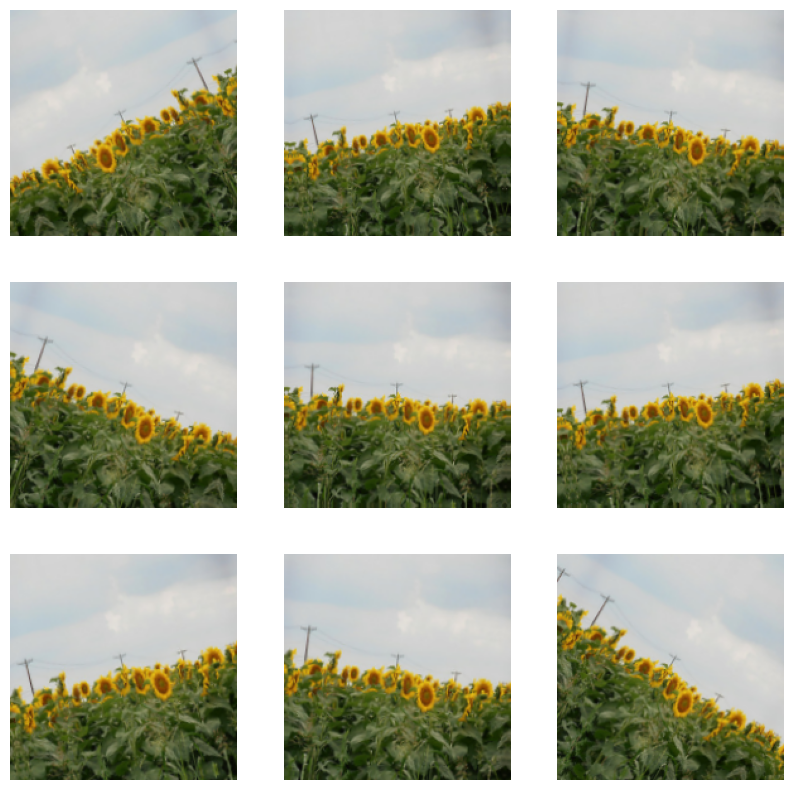

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
model = keras.Sequential([
    data_augmentation,
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [30]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs)

Epoch 1/15
92/92 [==============================] - 8s 32ms/step - loss: 1.3730 - accuracy: 0.4111 - val_loss: 1.0800 - val_accuracy: 0.5599
Epoch 2/15
92/92 [==============================] - 3s 31ms/step - loss: 1.0539 - accuracy: 0.5800 - val_loss: 1.0228 - val_accuracy: 0.5858
Epoch 3/15
92/92 [==============================] - 3s 35ms/step - loss: 0.9394 - accuracy: 0.6298 - val_loss: 0.9814 - val_accuracy: 0.6213
Epoch 4/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8643 - accuracy: 0.6693 - val_loss: 0.8073 - val_accuracy: 0.6921
Epoch 5/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8047 - accuracy: 0.6918 - val_loss: 0.9704 - val_accuracy: 0.6144
Epoch 6/15
92/92 [==============================] - 3s 31ms/step - loss: 0.7642 - accuracy: 0.7037 - val_loss: 0.7883 - val_accuracy: 0.6866
Epoch 7/15
92/92 [==============================] - 3s 30ms/step - loss: 0.7083 - accuracy: 0.7289 - val_loss: 0.7860 - val_accuracy: 0.6730
Epoch 8/15
92

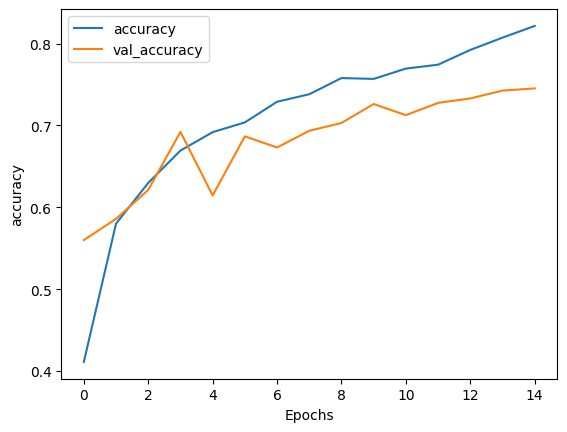

In [31]:
plot_graphs(history, 'accuracy')

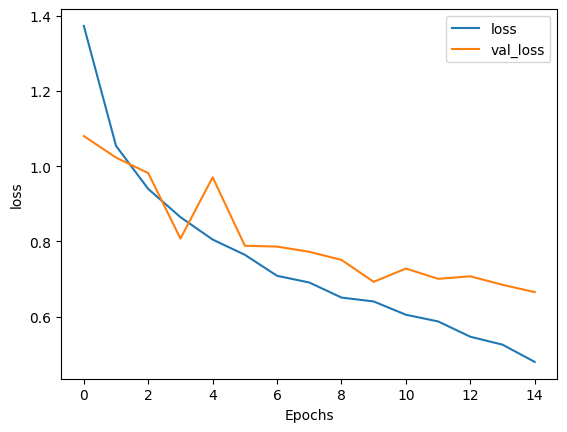

In [32]:
plot_graphs(history, 'loss')